<h1 class='font-effect-3d' style='font-family:Ewert; color:#ff355e'>🌐 Styling, Links, Helpful Functions, and Modules</h1>
#### [Github Repository](https://github.com/OlgaBelitskaya/deep_learning_projects/tree/master/DL_PP0) & [Colaboratory Version](https://colab.research.google.com/drive/1H2ArWH_1kYfkIoCbxleX-aHAozRVBAdB) & [SageMathCell Version](https://olgabelitskaya.github.io/DL_PP0_Solutions_SMC.html)

In [1]:
%%html
<style> 
@import url('https://fonts.googleapis.com/css?family=Ewert|Roboto&effect=3d'); 
a,h4 {color:slategray; font-family:Roboto; text-shadow:4px 4px 4px #aaa;}
span {color:black; font-family:Roboto; text-shadow:4px 4px 4px #aaa;}
div.output_prompt,div.output_area pre {color:slategray;}
div.input_prompt,div.output_subarea {color:#ff355e;}      
div.output_stderr pre {background-color:gainsboro;}  
div.output_stderr {background-color:slategrey;}     
</style>

In [2]:
import warnings; warnings.filterwarnings('ignore')
import pandas as pd,numpy as np,pylab as pl
import keras as ks,tensorflow as tf
import h5py,cv2; from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.preprocessing import image as kimage
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential,load_model,Model
from keras.layers import BatchNormalization,Conv2D,Dense
from keras.layers import LSTM,Flatten,Activation,Dropout
from keras.layers.advanced_activations import PReLU,LeakyReLU
from keras.layers import MaxPooling2D,GlobalMaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
fpath='../input/flower-color-images/'
fw='weights.best.flowers.hdf5'
fpath2='../input/inceptionv3/'
fw2='inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
fpath3='../input/vgg16/'
fw3='vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
from keras import __version__
print('keras version:', __version__)
print('tensorflow version:', tf.__version__)

Using TensorFlow backend.


keras version: 2.3.1
tensorflow version: 2.1.0


In [3]:
def history_plot(fit_history):
    pl.figure(figsize=(12,10)); pl.subplot(211)
    keys=list(fit_history.history.keys())[0:4]
    pl.plot(fit_history.history[keys[0]],
            color='slategray',label='train')
    pl.plot(fit_history.history[keys[2]],
            color='#ff355e',label='valid')
    pl.xlabel("Epochs"); pl.ylabel("Loss")
    pl.legend(); pl.grid()
    pl.title('Loss Function')     
    pl.subplot(212)
    pl.plot(fit_history.history[keys[1]],
            color='slategray',label='train')
    pl.plot(fit_history.history[keys[3]],
            color='#ff355e',label='valid')
    pl.xlabel("Epochs"); pl.ylabel("Accuracy")    
    pl.legend(); pl.grid()
    pl.title('Accuracy'); pl.show()

In [4]:
tpu=tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy=tf.distribute.experimental.TPUStrategy(tpu)

<h1 class='font-effect-3d' style='font-family:Ewert; color:#ff355e'>🌐 Data Exploration</h1>

Images => array shape: (210, 128, 128, 3)
Labels => array shape: (210, 10)


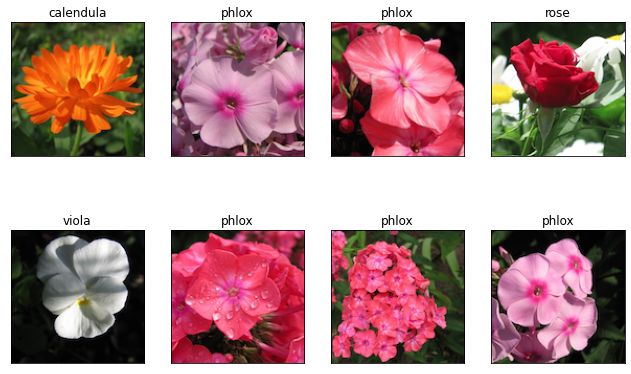

In [5]:
f=h5py.File(fpath+'FlowerColorImages.h5','r')
keys=list(f.keys())
images=np.array(f[keys[0]])/255
labels=np.array(f[keys[1]])
names=['phlox','rose','calendula','iris',
       'max chrysanthemum','bellflower','viola',
       'rudbeckia laciniata','peony','aquilegia']
fig=pl.figure(figsize=(11,7))
n=np.random.randint(1,30)
for i in range(n,n+8):
    ax=fig.add_subplot(2,4,i-n+1,\
    xticks=[],yticks=[],title=names[labels[i]])
    ax.imshow((images[i]))
labels=to_categorical(labels,10)
st1='Images => array shape: %s'
st2='Labels => array shape: %s'
print(st1%str(images.shape))
print(st2%str(labels.shape))

In [6]:
x_train,x_test,y_train,y_test=\
train_test_split(images,labels,test_size=.1,random_state=1)
m=int(len(x_test)/2)
x_valid,y_valid=x_test[:m],y_test[:m]
x_test,y_test=x_test[m:],y_test[m:]
print([x_train.shape,x_test.shape,x_valid.shape,
       y_train.shape,y_test.shape,y_valid.shape])

[(189, 128, 128, 3), (11, 128, 128, 3), (10, 128, 128, 3), (189, 10), (11, 10), (10, 10)]


<h1 class='font-effect-3d' style='font-family:Ewert; color:#ff355e'>🌐 Keras Applications</h1>
#### InceptionV3

In [7]:
with tpu_strategy.scope():
    iv3base_model=InceptionV3(weights=fpath2+fw2,include_top=False)
x=iv3base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(512,activation='relu')(x)
y=Dense(10,activation='softmax')(x)
with tpu_strategy.scope():
    iv3_model=Model(inputs=iv3base_model.input,outputs=y)
# freezing InceptionV3 convolutional layers
for layer in iv3base_model.layers:
    layer.trainable=False
with tpu_strategy.scope():
    iv3_model.compile(loss='categorical_crossentropy',
                      optimizer='adam',metrics=['accuracy'])

In [8]:
steps,epochs=189,10
data_generator=kimage\
.ImageDataGenerator(shear_range=.2,zoom_range=.2, 
                    horizontal_flip=True)
checkpointer=ModelCheckpoint(filepath=fw,save_best_only=True,verbose=2)
lr_reduction=ReduceLROnPlateau(monitor='val_loss',verbose=2,
                               patience=5,factor=.8)
history=iv3_model.fit_generator(data_generator\
.flow(x_train,y_train,batch_size=64),\
steps_per_epoch=steps,epochs=epochs,verbose=2, 
validation_data=(x_valid,y_valid), \
callbacks=[checkpointer,lr_reduction])

Epoch 1/10
 - 48s - loss: 0.4486 - accuracy: 0.8727 - val_loss: 5.6087 - val_accuracy: 0.5000

Epoch 00001: val_loss improved from inf to 5.60873, saving model to weights.best.flowers.hdf5
Epoch 2/10
 - 45s - loss: 0.1251 - accuracy: 0.9657 - val_loss: 10.6393 - val_accuracy: 0.2000

Epoch 00002: val_loss did not improve from 5.60873
Epoch 3/10
 - 45s - loss: 0.0976 - accuracy: 0.9698 - val_loss: 7.9352 - val_accuracy: 0.4000

Epoch 00003: val_loss did not improve from 5.60873
Epoch 4/10
 - 45s - loss: 0.0770 - accuracy: 0.9777 - val_loss: 5.8284 - val_accuracy: 0.5000

Epoch 00004: val_loss did not improve from 5.60873
Epoch 5/10
 - 44s - loss: 0.0729 - accuracy: 0.9784 - val_loss: 10.5524 - val_accuracy: 0.5000

Epoch 00005: val_loss did not improve from 5.60873
Epoch 6/10
 - 45s - loss: 0.0608 - accuracy: 0.9820 - val_loss: 8.3654 - val_accuracy: 0.4000

Epoch 00006: val_loss did not improve from 5.60873

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.000800000037997961.

In [9]:
#for i,layer in enumerate(iv3base_model.layers[173:]):
#    print(i,layer.name)

In [10]:
# Unfreeze the layers [173:]
for layer in iv3_model.layers[:173]:
    layer.trainable=False
for layer in iv3_model.layers[173:]:
    layer.trainable=True   
with tpu_strategy.scope():
    iv3_model.compile(loss='categorical_crossentropy',
                      optimizer='adam',metrics=['accuracy'])

In [11]:
checkpointer=ModelCheckpoint(filepath=fw,save_best_only=True,verbose=2)
lr_reduction=ReduceLROnPlateau(monitor='val_loss',verbose=2,
                               patience=5,factor=.8)
history=iv3_model.fit_generator(data_generator\
.flow(x_train,y_train,batch_size=64),\
steps_per_epoch=50,epochs=epochs,verbose=2,\
validation_data=(x_valid,y_valid),\
callbacks=[checkpointer,lr_reduction])

Epoch 1/10
 - 32s - loss: 0.5067 - accuracy: 0.9594 - val_loss: 97.6633 - val_accuracy: 0.3000

Epoch 00001: val_loss improved from inf to 97.66326, saving model to weights.best.flowers.hdf5
Epoch 2/10
 - 21s - loss: 0.0702 - accuracy: 0.9921 - val_loss: 19.8587 - val_accuracy: 0.5000

Epoch 00002: val_loss improved from 97.66326 to 19.85868, saving model to weights.best.flowers.hdf5
Epoch 3/10
 - 21s - loss: 0.0336 - accuracy: 0.9937 - val_loss: 8.7734 - val_accuracy: 0.5000

Epoch 00003: val_loss improved from 19.85868 to 8.77336, saving model to weights.best.flowers.hdf5
Epoch 4/10
 - 20s - loss: 0.0539 - accuracy: 0.9924 - val_loss: 8.8512 - val_accuracy: 0.8000

Epoch 00004: val_loss did not improve from 8.77336
Epoch 5/10
 - 20s - loss: 9.2661e-04 - accuracy: 1.0000 - val_loss: 7.2654 - val_accuracy: 0.7000

Epoch 00005: val_loss improved from 8.77336 to 7.26540, saving model to weights.best.flowers.hdf5
Epoch 6/10
 - 20s - loss: 0.0114 - accuracy: 0.9965 - val_loss: 5.0479 - val

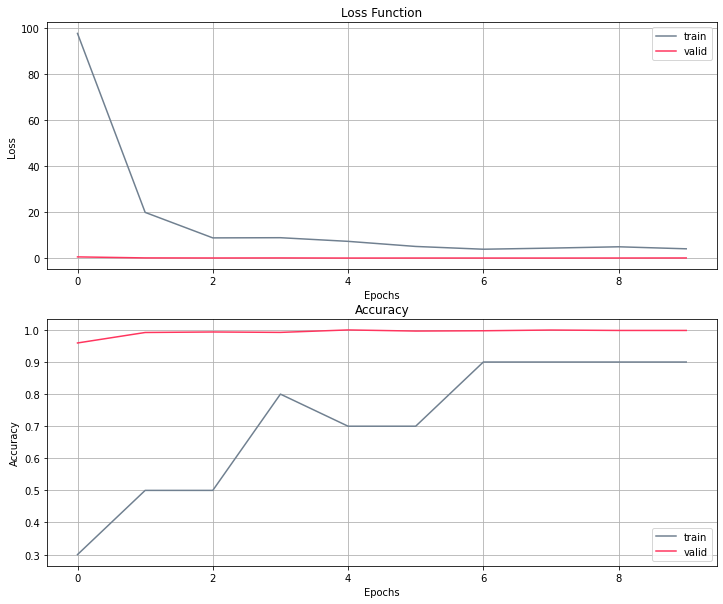

11/11 [==============================] - 0s 17ms/step


[2.158140182495117, 0.4545454680919647]

In [12]:
history_plot(history)
iv3_model.load_weights(fw)
iv3_model.evaluate(x_test,y_test)

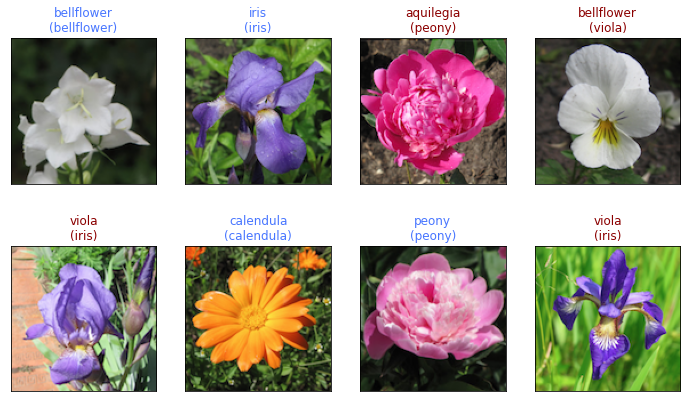

In [13]:
y_test_predict=np.array([np.argmax(x) 
                         for x in iv3_model.predict(x_test)])
fig=pl.figure(figsize=(12,7))
randch=np.random.choice(x_test.shape[0],size=8,replace=False)
for i,idx in enumerate(randch):
    ax=fig.add_subplot(2,4,i+1,xticks=[],yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx=y_test_predict[idx]
    true_idx=np.argmax(y_test[idx])
    ax.set_title("{}\n({})".format(names[pred_idx],names[true_idx]),
                 color=("#4876ff" if pred_idx==true_idx else "darkred"))
pl.show()

#### VGG16

In [14]:
with tpu_strategy.scope():
    vgg16base_model=VGG16(weights=fpath3+fw3,
                          include_top=False)
pvx_train=vgg16base_model.predict(x_train)
pvx_valid=vgg16base_model.predict(x_valid)
pvx_test=vgg16base_model.predict(x_test)
sh=pvx_train.shape[1:]

In [15]:
def vgg16model():
    model=Sequential()  
    model.add(GlobalAveragePooling2D(input_shape=sh))   
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=.02))
    model.add(Dropout(.5))        
    model.add(Dense(64))
    model.add(LeakyReLU(alpha=.02))
    model.add(Dropout(.25))   
    model.add(Dense(10,activation='softmax'))    
    model.compile(loss='categorical_crossentropy',
                  optimizer='nadam',metrics=['accuracy'])
    return model
vgg16model=vgg16model()

In [16]:
checkpointer=ModelCheckpoint(filepath=fw,verbose=2,save_best_only=True)
lr_reduction=ReduceLROnPlateau(monitor='val_loss',patience=5,
                               verbose=2,factor=.8)
estopping=EarlyStopping(monitor='val_loss',patience=30,verbose=2)
history=vgg16model.fit(pvx_train,y_train, 
                       validation_data=(pvx_valid,y_valid), 
                       epochs=100,batch_size=64,verbose=2, 
                       callbacks=[checkpointer,lr_reduction,estopping])

Train on 189 samples, validate on 10 samples
Epoch 1/100
 - 0s - loss: 2.4186 - accuracy: 0.1111 - val_loss: 2.0664 - val_accuracy: 0.4000

Epoch 00001: val_loss improved from inf to 2.06639, saving model to weights.best.flowers.hdf5
Epoch 2/100
 - 0s - loss: 2.2381 - accuracy: 0.1958 - val_loss: 1.8940 - val_accuracy: 0.4000

Epoch 00002: val_loss improved from 2.06639 to 1.89399, saving model to weights.best.flowers.hdf5
Epoch 3/100
 - 0s - loss: 2.1696 - accuracy: 0.1693 - val_loss: 1.7762 - val_accuracy: 0.5000

Epoch 00003: val_loss improved from 1.89399 to 1.77616, saving model to weights.best.flowers.hdf5
Epoch 4/100
 - 0s - loss: 2.0638 - accuracy: 0.2963 - val_loss: 1.6002 - val_accuracy: 0.4000

Epoch 00004: val_loss improved from 1.77616 to 1.60016, saving model to weights.best.flowers.hdf5
Epoch 5/100
 - 0s - loss: 1.9067 - accuracy: 0.3386 - val_loss: 1.8878 - val_accuracy: 0.5000

Epoch 00005: val_loss did not improve from 1.60016
Epoch 6/100
 - 0s - loss: 1.7906 - accura

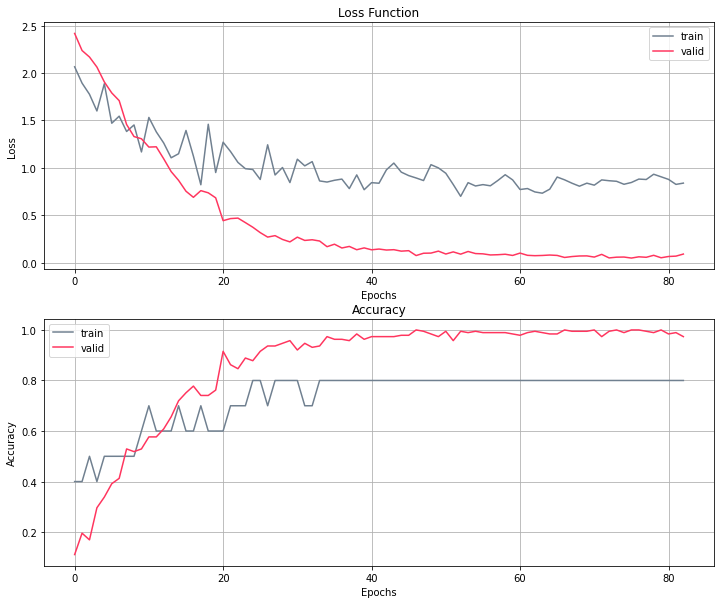

11/11 [==============================] - 0s 345us/step


[0.46995431184768677, 0.8181818127632141]

In [17]:
history_plot(history)
vgg16model.load_weights(fw)
vgg16model.evaluate(pvx_test,y_test)